<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Flower%20Classification%20with%20TPUs/banner.png" width="1000"></center>
<br>
<center><h1>Flower Classification with TPUs - EDA and Baseline</h1></center>
<br>


> Tham khảo từ [work of](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu) Martin Görner

## Mô tả dữ liệu đầu vào

Bộ data bao gồm hình ảnh của nhiều bông hoa. Nhiệm vụ là xây dựng một bộ phân loại hình ảnh bông hoa này thuộc loài hoa nào.

Các file hình ảnh được lưu dưới dạng tfrecord. Định dạng TFRecord là định dạng vùng chứa thường được sử dụng trong Tensorflow để nhóm và phân đoạn các tệp dữ liệu dữ liệu nhằm đạt được tốc độ đào tạo tối ưu. Mỗi file gồm id, label ( class của sample,dành cho dữ liệu train và img cho nhiều hình ảnh.

    - train/*.tfrec: các training sample, bao gồm các nhãn 
    - val/*.tfrec: các pre-split training samples với các nhãn  nhằm kiểm tra hiệu suất model trên TPU.
    - test/*.tfrec: các sample không có nhãn  - dùng để dự đoán hoa trong hình thuộc loại nào
    - sample_submission.csv: file kết quả với định dạng như sau
        - id: ID duy nhất cho mỗi sample
        -label( training data) loại hoa được đại diện bởi mẫu

In [ ]:
!pip install --quiet efficientnet

import math, os, re, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

import tensorflow.keras.layers as L
from tensorflow import keras
from tensorflow.keras import optimizers, applications, Sequential, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import efficientnet.tfkeras as efn

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

### Cấu hình TPU 

In [ ]:
# Phát hiện  TPU hoặc GPU 
# Phát hiện phần cứng, return distribution strategy phù hợp
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Model parameters

In [ ]:
BATCH_SIZE = 16 * REPLICAS
WARMUP_EPOCHS = 3
WARMUP_LEARNING_RATE = 1e-4 * REPLICAS
EPOCHS = 20
LEARNING_RATE = 3e-5 * REPLICAS
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 104
ES_PATIENCE = 5

In [ ]:
model_path = f'model_{HEIGHT}x{WIDTH}.h5'

GCS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') + f'/tfrecords-jpeg-{HEIGHT}x{WIDTH}'

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 
    'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 
    'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 
    'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'cosmos',  'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort',  'siam tulip', 
    'lenten rose', 'barberton daisy', 'daffodil',  'sword lily', 'poinsettia', 
    'bolero deep blue',  'wallflower', 'marigold', 'buttercup', 'daisy', 
    'common dandelion', 'petunia', 'wild pansy', 'primula',  'sunflower', 
    'lilac hibiscus', 'bishop of llandaff', 'gaura',  'geranium', 'orange dahlia', 
    'pink-yellow dahlia', 'cautleya spicata',  'japanese anemone', 
    'black-eyed susan', 'silverbush', 'californian poppy',  'osteospermum', 
    'spring crocus', 'iris', 'windflower',  'tree poppy', 'gazania', 'azalea', 
    'water lily',  'rose', 'thorn apple', 'morning glory', 'passion flower',  
    'lotus', 'toad lily', 'anthurium', 'frangipani',  'clematis', 'hibiscus', 
    'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 
    'watercress',  'canna lily', 'hippeastrum ', 'bee balm', 'pink quill',  
    'foxglove', 'bougainvillea', 'camellia', 'mallow',  'mexican petunia',  
    'bromelia', 'blanket flower', 'trumpet creeper',  'blackberry lily', 
    'common tulip', 'wild rose']

In [ ]:
# Một số hàm sử dụng cho tập dữ liệu
AUTO = tf.data.experimental.AUTOTUNE # Đọc API từ nhiều tệp nếu có

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

#đọc data có nhãn (Train và val)
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

#đọc data không nhãn (test)
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # trả về tập dữ liệu các hình ảnh

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # Tự động xen kẽ các lần đọc từ nhiều file
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # Trả về dataset của các cặp (image, label) nếu được gắn nhãn = True hoặc các cặp (image, id)  nếu được gắn nhãn = False
    return dataset

def data_augment(image, label):
    crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
        
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, lower=0, upper=2)
    image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_training_dataset_preview(ordered=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # số lượng mục dữ liệu được viết dưới tên .tfrec files, tức là flowers00-230.tfrec = 230 mục dữ liệu
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
# Các hàm trực quan hóa 
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: 
        numpy_labels = [None for _ in enumerate(numpy_images)]
    
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
   
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size , spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Trực quan hóa các dự đoán mô hình
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# EDA

## Sơ lược về datasets

In [ ]:
# Train data
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
train_dataset = get_training_dataset_preview(ordered=True)
y_train = next(iter(train_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print(f'Number of training images {NUM_TRAINING_IMAGES}')

# Validation data
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
valid_dataset = get_validation_dataset(ordered=True)
y_valid = next(iter(valid_dataset.unbatch().map(lambda image, label: label).batch(NUM_VALIDATION_IMAGES))).numpy()
print(f'Number of validation images {NUM_VALIDATION_IMAGES}')

# Test data
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print(f'Number of test images {NUM_TEST_IMAGES}')
test_dataset = get_test_dataset(ordered=True)

## Một số mẫu từ dataset

### Train samples

In [ ]:
display_batch_of_images(next(iter(train_dataset.unbatch().batch(20))))

### Validation samples

In [ ]:
display_batch_of_images(next(iter(valid_dataset.unbatch().batch(20))))

### Test samples

In [ ]:
display_batch_of_images(next(iter(test_dataset.unbatch().batch(20))))

Nhận xét ban đầu khi xem qua các mẫu: chất lượng hình ảnh trong dataset có vẻ rất nhất quán trên toàn bộ tập dữ liệu. Điều này sẽ giúp mô hình dễ dàng tổng quát hóa hơn, tập dữ liệu cũng có vẻ khá đa dạng về loại hoa, nhưng chúng ta sẽ xem xét điều này một cách chi tiết hơn .

## Phân phối nhãn

In [ ]:
train_agg = np.asarray([[label, (y_train == index).sum()] for index, label in enumerate(CLASSES)])
valid_agg = np.asarray([[label, (y_valid == index).sum()] for index, label in enumerate(CLASSES)])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 64))

ax1 = sns.barplot(x=train_agg[...,1], y=train_agg[...,0], order=CLASSES, ax=ax1)
ax1.set_title('Train', fontsize=30)
ax1.tick_params(labelsize=16)

ax2 = sns.barplot(x=valid_agg[...,1], y=valid_agg[...,0], order=CLASSES, ax=ax2)
ax2.set_title('Validation', fontsize=30)
ax2.tick_params(labelsize=16)

plt.show()

Như chúng ta có thể thấy các bộ dữ liệu phần lớn không cân bằng, nhưng bộ xác thực và bộ xác nhận có sự phân phối tương tự.

In [ ]:
for img, label in train_dataset.take(1):
    data = [img[0:32,:,:,:].numpy(),label[0:32].numpy()]

In [ ]:
data[0].shape[1:4]

# Model

Mô hình sử dụng trong bài toán này là mạng neuron tích chập (CNN) - một trong những mô hình Deep Learning tiên tiến giúp cho chúng ta xây dựng được những hệ thống thông minh với độ chính xác cao hơn hiện nay. Trong đó, xác định đối tượng và nhận dạng khuôn mặt là 1 trong số những lĩnh vực mà CNN được sử dụng rộng rãi. CNN phân loại hình ảnh bằng cách lấy 1 hình ảnh đầu vào, xử lý và phân loại nó theo các hạng mục nhất định. Dựa trên độ phân giải hình ảnh, máy tính sẽ thấy H x W x D.

## Convulution là gì?
Tích chập được sử dụng đầu tiên trong xử lý tín hiệu số (Signal processing). Nhờ vào nguyên lý biến đổi thông tin, các nhà khoa học đã áp dụng kỹ thuật này vào xử lý ảnh và video số.

Để dễ hình dung, ta có thể xem tích chập như một của sổ trượt (sliding window) áp đặt lên một ma trận. Bạn có thể theo dõi cơ chế của tích chập qua hình minh họa bên dưới.
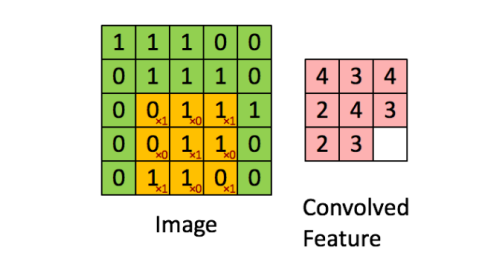

Ma trận bên trái là một bức ảnh đen trắng. Mỗi giá trị của ma trận tương đương với một điểm ảnh (pixel), 0 là màu đen, 1 là màu trắng (nếu là ảnh grayscale thì giá trị biến thiên từ 0 đến 255).

Sliding window còn có tên gọi là kernel, filter hay feature detector. Ở đây, ta dùng một ma trận filter 3×3 nhân từng thành phần tương ứng (element-wise) với ma trận ảnh bên trái. Gía trị đầu ra do tích của các thành phần này cộng lại.

Kết quả của tích chập là một ma trận (convoled feature) sinh ra từ việc trượt ma  trận filter và thực hiện tích chập cùng lúc lên toàn bộ ma trận ảnh bên trái.




## Mô hình mạng neuron tích chập

Bây giờ, Chúng ta đã biết thế nào là convolution. Vậy CNNs là gì? CNNs chỉ đơn giản gồm một vài layer của convolution kết hợp với các hàm kích hoạt phi tuyến (nonlinear activation function) như ReLU hay tanh để tạo ra thông tin trừu tượng hơn (abstract/higher-level) cho các layer tiếp theo.

Trong mô hình Feedforward Neural Network (mạng nơ-ron truyền thẳng), các layer kết nối trực tiếp với nhau thông qua một trọng số w (weighted vector). Các layer này còn được gọi là có kết nối đầy đủ (fully connected layer) hay affine layer.

Trong mô hình CNNs thì ngược lại. Các layer liên kết được với nhau thông qua cơ chế convolution. Layer tiếp theo là kết quả convolution từ layer trước đó, nhờ vậy mà ta có được các kết nối cục bộ. Nghĩa là mỗi nơ-ron ở layer tiếp theo sinh ra từ filter áp đặt lên một vùng ảnh cục bộ của nơ-ron layer trước đó.

Mỗi layer như vậy được  áp đặt các filter khác nhau, thông thường có vài trăm đến vài nghìn filter như vậy. Một số layer khác như pooling/subsampling layer dùng để chắt lọc lại các thông tin hữu ích hơn (loại bỏ các thông tin nhiễu).
Tuy nhiên, ta sẽ không đi sâu vào khái niệm của các layer này.

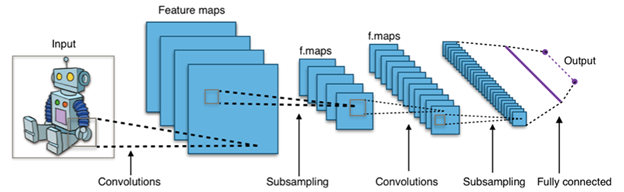

CNNs có tính bất biến và tính kết hợp cục bộ (Location Invariance and Compositionality). Với cùng một đối tượng, nếu đối tượng này được chiếu theo các gốc độ khác nhau (translation, rotation, scaling) thì độ chính xác của thuật toán sẽ bị ảnh hưởng đáng kể. Pooling layer sẽ cho bạn tính bất biến đối với phép dịch chuyển (translation), phép quay (rotation) và phép co giãn (scaling). 	

Tính kết hợp cục bộ cho ta các cấp độ biểu diễn thông tin từ mức độ thấp đến mức độ cao và trừu tượng hơn thông qua convolution từ các filter. Đó là lý do tại sao CNNs cho ra mô hình với độ chính xác rất cao. Cũng giống như cách con người nhận biết các vật thể trong tự nhiên. Ta phân biệt được một con chó với một con mèo nhờ vào các đặc trưng từ mức độ thấp (có 4 chân, có đuôi) đến mức độ cao (dáng đi, hình thể, màu lông)


## Sử dụng trong bài toán nhận diện

Mạng tích chập sử dụng 3 ý tưởng cơ bản: các trường tiếp nhận cục bộ (local receptive field), trọng số chia sẻ (shared weights) và tổng hợp (pooling). Chúng ta hãy xem xét lần lượt từng ý tưởng. Trường tiếp nhận cục bộ (Local receptive fields): Trong các tầng kết nối đầy đủ được chỉ ra trước đây, đầu vào đã được mô tả là một đường thẳng đứng chứa các nơron. Trong mạng tích chập, ta sẽ thay thế các đầu vào là 28 × 28 nơron, giá trị tương ứng với 28 x28 cường độ điểm ảnh mà chúng ta sử dụng:

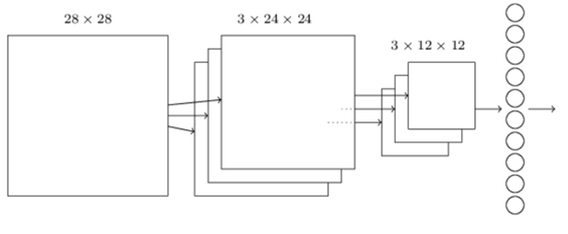
Như thường lệ chúng ta sẽ kết nối các điểm ảnh đầu vào cho các nơron ở tầng ẩn. Nhưng chúng ta sẽ không kết nối mỗi điểm ảnh đầu vào cho mỗi neuron ẩn. Thay vào đó, chúng ta chỉ kết nối trong phạm vi nhỏ, các vùng cục bộ của bức ảnh.

Để được chính xác hơn, mỗi nơron trong lớp ẩn đầu tiên sẽ được kết nối với một vùng nhỏ của các nơron đầu vào, ví dụ, một vùng 5 × 5, tương ứng với 25 điểm ảnh đầu vào. 

Vùng đó trong bức ảnh đầu vào được gọi là vùng tiếp nhận cục bộ cho nơron ẩn. Đó là một cửa sổ nhỏ trên các điểm ảnh đầu vào. Mỗi kết nối sẽ học một trọng số. Và nơron ẩn cũng sẽ học một độ lệch (overall bias). Bạn có thể hiểu rằng nơron lớp ẩn cụ thể là học để phân tích trường tiếp nhận cục bộ cụ thể của nó.

Sau đó chúng ta trượt trường tiếp nhận cục bộ trên toàn bộ bức ảnh. Đối với mỗi trường tiếp nhận cục bộ, có một nơron ẩn khác trong tầng ẩn đầu tiên. Để minh họa điều này một cách cụ thể, chúng ta hãy bắt đầu với một trường tiếp nhận cục bộ ở góc trên bên trái

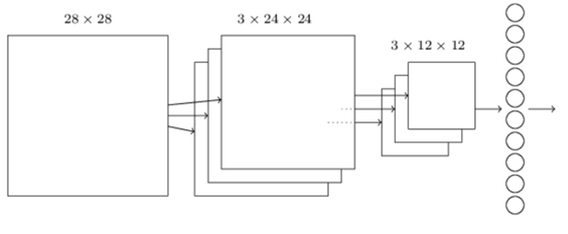

Sau đó dịch filter qua bên phải một cột sẽ tạo được neuron ẩn thứ 2.

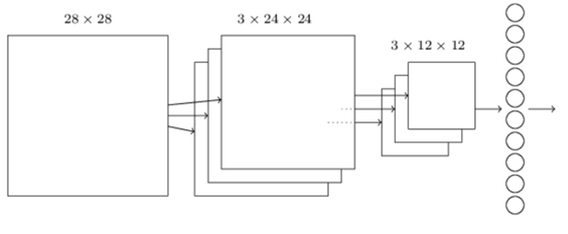

Đối với bài toán nhận dạng ảnh người ta thường gọi ma trận lớp đầu vào là feature map, trọng số xác định các đặc trương là shared weight và độ lệch xác định một feature map là shared bias. Như vậy đơn giản nhất là qua các bước trên chúng ta chỉ có 1 feature map. Tuy nhiên trong nhận dạng ảnh chúng ta cần nhiều hơn một feature map.

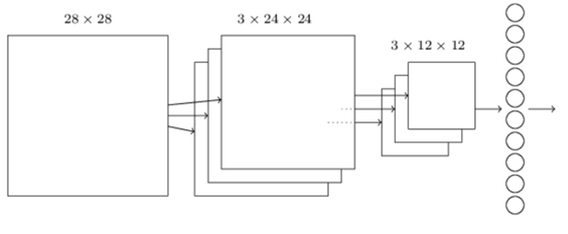

Như vậy, local receptive field thích hợp cho việc phân tách dữ liệu ảnh, giúp chọn ra những vùng ảnh có giá trị nhất cho việc đánh giá phân lớp.

Trọng số chia sẻ (shared weight and bias)

Đầu tiên, các trọng số cho mỗi filter (kernel) phải giống nhau. Tất cả các nơ-ron trong lớp ẩn đầu sẽ phát hiện chính xác feature tương tự chỉ ở các vị trí khác nhau trong hình ảnh đầu vào. Chúng ta gọi việc map từ input layer sang hidden layer là một feature map. Vậy mối quan hệ giữa số lượng Feature map với số lượng tham số là gì?

Chúng ta thấy mỗi fearture map cần 25 = 5x5 shared weight và 1 shared bias. Như vậy mỗi feature map cần 5x5+1 = 26 tham số. Như vậy nếu có 10 feature map thì có 10x26 = 260 tham số. Chúng ta xét lại nếu layer đầu tiên có kết nối đầy đủ nghĩa là chúng ta có 28x28=784 neuron đầu vào như vậy ta chỉ có 30 neuron ẩn. Như vậy ta cần 28x28x30 shared weight và 30 shared bias. Tổng số tham số là 28x28x30+30 tham số lớn hơn nhiều so với CNN. Ví dụ vừa rồi chỉ mô tả để thấy được sự ước lượng số lượng tham số chứ chúng ta không so sánh được trực tiếp vì 2 mô hình khác nhau. Nhưng điều chắc chắn là nếu mô hình có số lượng tham số ít hơn thì nó sẽ chạy nhanh hơn.

Tóm lại, một convolutional layer bao gồm các feature map khác nhau. Mỗi một feature map giúp detect một vài feature trong bức ảnh. Lợi ích lớn nhất của trọng số chia sẻ là giảm tối đa số lượng tham số trong mạng CNN.

Lớp pooling thường được sử dụng ngay sau lớp convulational để đơn giản hóa thông tin đầu ra để giảm bớt số lượng neuron. Thủ tục pooling phổ biến là max-pooling, thủ tục này chọn giá trị lớn nhất trong vùng đầu vào 2x2.

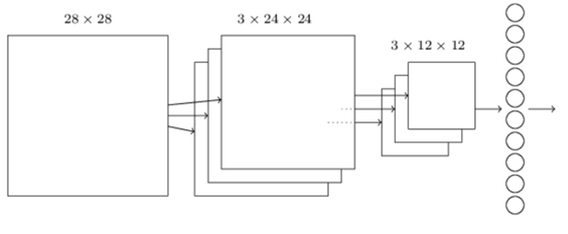

Như vậy qua lớp Max Pooling thì số lượng neuron giảm đi phân nửa. Trong một mạng CNN có nhiều Feature Map nên mỗi Feature Map chúng ta sẽ cho mỗi Max Pooling khác nhau. Chúng ta có thể thấy rằng Max Pooling là cách hỏi xem trong các đặc trưng này thì đặc trưng nào là đặc trưng nhất. Ngoài Max Pooling còn có L2 Pooling.

Cuối cùng ta đặt tất cả các lớp lại với nhau thành một CNN với đầu ra gồm các neuron với số lượng tùy bài toán. 2 lớp cuối cùng của các kết nối trong mạng là một lớp đầy đủ kết nối (fully connected layer) . Lớp này nối mọi nơron từ lớp max pooled tới mọi nơron của tầng ra.

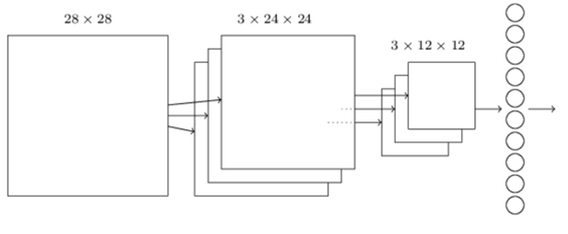





In [ ]:
# def create_model(input_shape, N_CLASSES):
#     base_model = efn.EfficientNetB6(weights='/kaggle/input/efficientnet/efficientnet-b6_noisy-student_notop.h5', 
#                                     include_top=False,
#                                     input_shape=input_shape)

#     base_model.trainable = False # Freeze layers
#     model = tf.keras.Sequential([
#         base_model,
#         L.GlobalAveragePooling2D(),
#         L.Dense(N_CLASSES, activation='softmax')
#     ])
    
#     return model

In [ ]:
#cusstom
def create_model(input_shape, N_CLASSES):
    base_model =tf.keras.applications.VGG16(weights = 'imagenet', 
                                    include_top=False,
                                    input_shape=input_shape)

    base_model.trainable = False # Freeze layers
    model = tf.keras.Sequential([
        base_model,
        L.GlobalAveragePooling2D(),
        L.Dense(N_CLASSES, activation='softmax')
    ])
    
    return model

# Warmup top layers

In [ ]:
with strategy.scope():
    model = create_model((None, None, CHANNELS), N_CLASSES)
    
metric_list = ['sparse_categorical_accuracy']

optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, 
              loss=losses.SparseCategoricalCrossentropy(), 
              metrics=metric_list)
model.summary()

In [ ]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
warmup_history = model.fit(x=get_training_dataset(), 
                           steps_per_epoch=STEPS_PER_EPOCH, 
                           validation_data=get_validation_dataset(),
                           epochs=WARMUP_EPOCHS, 
                           verbose=2).history

### Learning rate schedule

In [ ]:
LR_START = 0.00000001
LR_MIN = 0.000001
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Tinh chỉnh tất cả các lớp

In [ ]:
for layer in model.layers:
    layer.trainable = True # Unfreeze layers

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=0)

callback_list = [checkpoint, es, lr_callback]

optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=metric_list)
model.summary()

In [ ]:
history = model.fit(x=get_training_dataset(), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=get_validation_dataset(), 
                    callbacks=callback_list, 
                    epochs=20, 
                    verbose=2).history

## Model loss graph

In [ ]:
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(24, 12))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label=f'Train {metric}')
        axes[index].plot(history[f'val_{metric}'], label=f'Validation {metric}')
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

plot_metrics(history, metric_list=['loss', 'sparse_categorical_accuracy'])

# Đánh giá mô hình

## Train set

In [ ]:
x_train = train_dataset.map(lambda image, label: image)
train_preds = model.predict(x_train)
train_preds = np.argmax(train_preds, axis=-1)

print(classification_report(y_train, train_preds, target_names=CLASSES))

## Validation set

In [ ]:
x_valid = valid_dataset.map(lambda image, label: image)
valid_preds = model.predict(x_valid)
valid_preds = np.argmax(valid_preds, axis=-1)

print(classification_report(y_valid, valid_preds, target_names=CLASSES))

# Confusion matrix

## Train
Chia các confusion matrix thành 3 phần để rõ ràng hơn, ô thứ nhất có các lớp 1 từ 34, ô thứ hai 35 đến 69 và ô thứ ba có các lớp còn lại.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 45))
train_cfn_matrix = confusion_matrix(y_train, train_preds, labels=range(len(CLASSES)))
train_cfn_matrix = (train_cfn_matrix.T / train_cfn_matrix.sum(axis=1)).T
train_df_cm = pd.DataFrame(train_cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(train_df_cm, cmap='Blues').set_title('Train', fontsize=30)
plt.show()

## Validation

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 45))
valid_cfn_matrix = confusion_matrix(y_valid, valid_preds, labels=range(len(CLASSES)))
valid_cfn_matrix = (valid_cfn_matrix.T / valid_cfn_matrix.sum(axis=1)).T
valid_df_cm = pd.DataFrame(valid_cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(valid_df_cm, cmap=sns.cubehelix_palette(8)).set_title('Validation', fontsize=30)
plt.show()

# Hình dung các dự đoán

## Train set

In [ ]:
x_train_samp, y_train_samp = dataset_to_numpy_util(train_dataset, 12)
train_samp_preds = model.predict(x_train_samp, batch_size=12)
display_9_images_with_predictions(x_train_samp, train_samp_preds, y_train_samp)

## Validation set

In [ ]:
x_valid_samp, y_valid_samp = dataset_to_numpy_util(valid_dataset, 9)
valid_samp_preds = model.predict(x_valid_samp, batch_size=9)
display_9_images_with_predictions(x_valid_samp, valid_samp_preds, y_valid_samp)

# Kiểm tra các dự đoán

In [ ]:
x_test = test_dataset.map(lambda image, idnum: image)
test_preds = model.predict(x_test)
test_preds = np.argmax(test_preds, axis=-1)

In [ ]:
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

submission = pd.DataFrame(test_ids, columns=['id'])
submission['label'] = test_preds
submission.to_csv('submission.csv', index=False)
display(submission.head(10))